# Waiting-time SIR with EventQueue

This notebook demonstrates the **waiting-time formulation** of an SIR process.

What it does:
1. Each infected host schedules a recovery time and repeated contact times.
2. All events are stored in a global `EventQueue` ordered by event time.
3. Simulation advances by popping the next event in time order with `Gillespie` + queue backend.
4. We measure the distribution of infected individuals at a fixed final time across many trajectories.

In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Random
using Distributions
using StatsBase
using Plots
using MonteCarloX

  Activating project at `~/.julia/dev/MonteCarloX/notebooks`


In [2]:
mutable struct SIRWaitingTime
    rng::AbstractRNG
    P_dt_recovery::Exponential
    P_dt_contact::Exponential
    N::Int
    S::Int
    I::Int
    R::Int
    S0::Int
    I0::Int
    R0::Int
end

function SIRWaitingTime(mu, lambda, S0::Int, I0::Int, R0::Int; rng=Random.GLOBAL_RNG)
    N = S0 + I0 + R0
    return SIRWaitingTime(rng, Exponential(1 / mu), Exponential(1 / lambda), N, S0, I0, R0, S0, I0, R0)
end

function reset!(sys::SIRWaitingTime, rng::AbstractRNG)
    sys.rng = rng
    sys.S = sys.S0
    sys.I = sys.I0
    sys.R = sys.R0
    return sys
end

# event payload: (kind, linked_recovery_time)
# kind == 1: recovery event
# kind == 2: contact event

function schedule_next_contact!(queue::EventQueue{Tuple{Int,Float64}}, sys::SIRWaitingTime, recovery_time::Float64)
    t_contact = get_time(queue) + rand(sys.rng, sys.P_dt_contact)
    if t_contact < recovery_time
        add!(queue, (t_contact, (2, recovery_time)))
    end
end

function new_infection!(queue::EventQueue{Tuple{Int,Float64}}, sys::SIRWaitingTime)
    t_recovery = get_time(queue) + rand(sys.rng, sys.P_dt_recovery)
    add!(queue, (t_recovery, (1, t_recovery)))
    schedule_next_contact!(queue, sys, t_recovery)
end

function initialize!(queue::EventQueue{Tuple{Int,Float64}}, sys::SIRWaitingTime)
    for _ in 1:sys.I
        new_infection!(queue, sys)
    end
end

function update_waiting_time!(queue::EventQueue{Tuple{Int,Float64}}, event::Tuple{Int,Float64}, sys::SIRWaitingTime)
    kind, recovery_time = event
    if kind == 1
        sys.I -= 1
        sys.R += 1
    elseif kind == 2
        if rand(sys.rng) < sys.S / sys.N
            new_infection!(queue, sys)
            sys.S -= 1
            sys.I += 1
        end
        schedule_next_contact!(queue, sys, recovery_time)
    else
        error("unknown event kind")
    end
    return nothing
end

update_waiting_time! (generic function with 1 method)

In [3]:
using LinearAlgebra
function simulate_waiting_time_I_final(;
    mu=1/8,
    lambda=1/8,
    N=10_000,
    I0=1,
    t_final=14.0,
    trajectories=2_000,
    seed=1000
)
    S0, R0 = N - I0, 0
    hist_I = fit(Histogram, Int[], 0:200)
    hist_I.weights .= 0

    for n in 1:trajectories
        rng = MersenneTwister(seed + n)
        sys = SIRWaitingTime(mu, lambda, S0, I0, R0; rng=rng)
        queue = EventQueue{Tuple{Int,Float64}}(0.0)
        initialize!(queue, sys)

        alg = Gillespie(rng)
        while alg.time <= t_final
            dt, event = next(alg, queue)
            alg.time += dt
            event === nothing && break
            if alg.time <= t_final
                update_waiting_time!(queue, event, sys)
            end
        end

        I_measure = sys.I
        if I_measure in hist_I.edges[1]
            hist_I[I_measure] += 1
        end
    end

    return normalize(hist_I, mode=:pdf)
end

simulate_waiting_time_I_final (generic function with 1 method)

Estimated mean I(t_final): 1.028


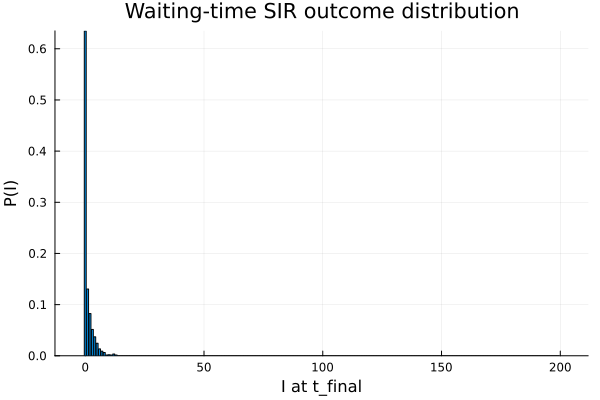

In [4]:
hist = simulate_waiting_time_I_final(trajectories=2_000, t_final=14.0)

x = hist.edges[1][1:end-1]
p = hist.weights
mean_I = sum(x .* p)
println("Estimated mean I(t_final): ", round(mean_I, digits=3))

bar(x, p, xlabel="I at t_final", ylabel="P(I)", legend=false, title="Waiting-time SIR outcome distribution")